<a href="https://colab.research.google.com/github/Yiru-Wang0123/STA/blob/main/STA414_tut5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 5: MCMC
In this tutorial, we will step through implementations of MCMC methods to hopefully gain more intuition of how MCMC works.

## Quick review of motivation:

Back in lecture 4-2

![](https://drive.google.com/uc?export=view&id=1o_sRv8Yi0ydrg5WhWARaPw0C2PJ3DxTD)

While MCMC is a class of general sampling algorithms, we will focus on its applications in bayesian inference.

Consider a general probabilistic model:

![](https://drive.google.com/uc?export=view&id=1-LpGkrthnhmOE6_qyid5wCtb9GIkS-re)

$\mu$ and $x$ can both be groups of random variables with some arbitary interconnection, but they form an overall
bi-partite structure (e.g. image and label as $x$, neural network weights $\mu$).
We'll apply the standard assumtions here as well.
$\mu$ is some model parameter that we want to learn, and $x_1$ through $x_N$ are the training data.
Then the first task is to model/compute $p(\mu | x_1, ... , x_N)$. For brevity, define $D =  x_1, ... , x_N$.

Suppose that the prior $p(\mu)$ and the likelihoood $p(D|\mu)$ are not conjugates,
then we don't have a closed form expression for $p(\mu|D)$.

Using Bayes' rule, we have:
$$p(\mu|D) = \frac{p(D|\mu)p(\mu)}{p(D)}$$

The $p(D)$ in the denominator is often intractable, but we have seen (and you will implement in assignment 2)
exact inference methods such as belief propagation that do not need to explicitly compute it over all $D$.
It can be shown that variable elimination has exponential complexity in the number of input variables in the
intermediate factors, and similarly for message passing. (In the assignment, this number is only 4).

Thus, we need approximate inference methods that can give us answers in polynomial time.

### Claim: A large sample from $\hat{\mu} \sim p(\mu|D)$ is almost as useful as $p(\mu|D)$

For instance, if we want to draw a new sample of $x$ given observed data $p(x|D)$:

$$p(x|D) = \int_{\Omega}p(x|\mu)p(\mu|D)d\mu$$

This expression for $p(x|D)$ is called the *posterior predictive* distribution.

Having $\hat{\mu}$ drawn from $p(\mu|D)$, we can use ancestral sampling, and simply draw $\hat{x} \sim p(x|\mu=\hat{\mu})$.
The resulting $\hat{x}$ will match the distribution $p(x|D)$, without the need of explicitly computing $p(\mu|D)$.


The sample $\hat{\mu}$ is also sufficient for regression/classification tasks. Suppose that we have a dataset $D=\{(x_i,y_i)\}_{i=1}^{N}$
and the goal is to predict $p(y_{new}|x_{new}, D)$. (As nice and principled bayesians) Our approach is to build a conditional likelihood model $p(y_i|x_i, \mu)$,
choose a prior $p(\mu)$, and write out the joint probability:

$$p(y_1, ..., y_N, x_1, ..., x_N, \mu) = \prod_{i=1}^{N}p(y_i|x_i,\mu_i)p(\mu_i)p(x_i)$$

And since x is observed, we have:
$$p(y_1, ..., y_N, \mu|x_1, ..., x_N) = \prod_{i=1}^{N}p(y_i|x_i,\mu_i)p(\mu_i)$$

Suppose that we have a sample of $\hat{\mu} \sim p(\mu|D)$, then we can empirically estimate the expectation of $y$ on a
new $x$ as follows:

$$E[y|x, D] = \int_{\mathbb{Y}} y d F(y | x, D) = \int_{\mathbb{Y}} y \int_{\Omega} p(y,\mu | x, D) d\mu dy$$

$$=\int_{\mathbb{Y}} y \int_{\Omega} p(y| \mu, x)p(\mu |D) d\mu dy = \int_{\Omega}p(\mu |D) \int_{\mathbb{Y}} y dy p(y| \mu, x) d\mu $$

$$=E_{\mu|D}[E_{y|\mu, x}[y]]$$
which can be estimated using $\hat{\mu}$ to parameterize $p(y|x, \mu)$, and then doing simple monte-carlo on $y|x, \mu$.

## Simple example of MCMC with Metropolis-Hastings


In MCMC, we build a markov chain with a specific stationary distribution in mind, and use it to produce sequences of
observed data, only to discard the sequential information (marginalize over time) while keeping the sampled states.

In Bayesian inference setting, the stationary distribution we aim for is the posterior $p(\mu|D)$. The state of the markov
chain are values of $\mu$, and the feasibility of the approach lies on the fact that we can exactly compute 'likelihood x prior' $\propto p(\mu|D)$.

Briefly, recall from the lecture:
![](https://drive.google.com/uc?export=view&id=1l5U2wijB-TpYqiuKsTT2A6Qq62MVeAj2)

We will run MH on a simple model for fitting baseball data. Our training data is 45 initial at-bats and hits for 18 players,
and we will explore different models for predicting the number of hits for the full season.

### Imports and Dataloading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.special import beta as B
from scipy.special import binom as nCk
import tqdm
from functools import partial
from IPython.display import display, clear_output

DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/EfronMorrisBB.txt"
baseball_dataset = pd.read_csv(DATA_URL, delimiter='\t')

In [ ]:
def train_test_split(pd_dataframe):
    """
    Training data - 45 initial at-bats and hits for each player.
    Validation data - Full season at-bats and hits for each player.
    """

    train_data = np.array(
        pd_dataframe[["At-Bats", "Hits"]].values, dtype=float
    )
    test_data = np.array(
        pd_dataframe[["SeasonAt-Bats", "SeasonHits"]].values,
        dtype=float,
    )
    first_name = pd_dataframe["FirstName"].values
    last_name = pd_dataframe["LastName"].values
    player_names = [
        " ".join([first, last]) for first, last in zip(first_name, last_name)
    ]
    return train_data, test_data, player_names


N = 18
train, test, pnames = train_test_split(baseball_dataset)

print(pnames[0])
print(train[0, :])

Roberto Clemente
[45. 18.]


### The model
Let $H_i$ denote the number of hits for player i, and $N_i$ the number of attempts. A natural model for $N$ and $H$ is the
binomial distribution $Bin(N, H, \mu) = \binom{N}{H}\mu^{H}(1-\mu)^{N-H}$.

In order to check our implementation, we will use a **conjugate prior** on $\mu$ which gives us analytical expressions for
$p(\mu|D)$. Specifically, we use the beta-distribution, $Beta(\mu, \alpha, \beta) = \frac{\mu^{\alpha-1}(1-\mu)^{\beta-1}}{B(\alpha, \beta)}$, where $B$ is the beta function.
$\alpha>0$ and $\beta>0$ are hyperparameters for the prior, and $\mu \in [0,1]$.

Since beta is a conjugate prior for binomial, we have the following expression for $p(\mu|D)$:

$$p(\mu|D) = Beta(\mu, \alpha + H, \beta + N - H)$$

Intuitively, $\alpha$ and $\beta$ can be interpreted as the number of hits and misses observed so far.
Initializing $\alpha=\beta=1$, let's code up the model from scratch in numpy:

In [ ]:
alpha=1.0
beta=1.0

def beta_pmf(p, a, b):
    return np.where(np.logical_and(p<=1, p>=0), (p**(a-1)*(1-p)**(b-1))/B(a,b), np.zeros_like(p))

def likelihood(x, n, p):
    return nCk(n, x) * p**x * (1-p)**(n-x)

def get_posterior(x, n, a, b):
    def gt_posterior(p):
        return (p ** (a + x - 1) * (1 - p) ** (b + n - x - 1)) / B(a + x, b + n - x)
    return gt_posterior


Let's just plot the prior and analytical posterior for the first player for now:

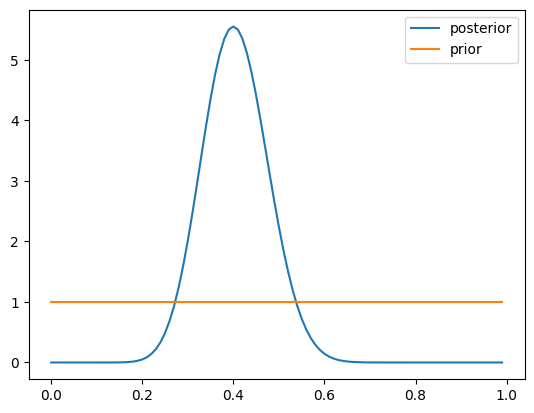

In [ ]:
ps = np.arange(0,1,0.01)
post = get_posterior(train[0, 1], train[0, 0], alpha, beta)
prior = partial(beta_pmf, a=alpha, b=beta)
ax = plt.subplot()
ax.plot(ps, post(ps), label='posterior')
ax.plot(ps, prior(ps), label='prior')
ax.legend()

If we have access to this analytical posterior, we can use simple monte-carlo to draw samples:

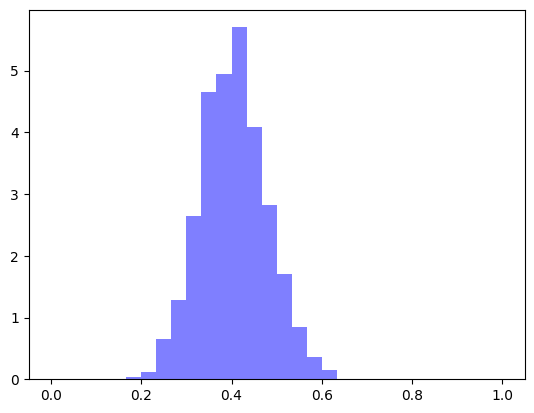

In [ ]:
simple_MC = np.random.beta(alpha+train[0, 1], beta+train[0, 0]-train[0, 1], 1000)
fig, axes = plt.subplots(1,1)
axes.hist(simple_MC, bins=30, range=(0,1), density=True, color='blue', alpha=0.5);

To perform MH, we still need to specify the proposal distribution $q(x'|x_t)$ ($x$ means $\mu$). In this simple example,
we will let $q(x'|x_t) \sim N(x_t,\sigma)$, with $\sigma$ as a hyperparameter set to $0.2$.

In [ ]:
def kernel(p, step_size=0.2):
    return p + np.random.normal(scale=step_size, size=p.size)

We are now ready to step through MH (plotting first 6 players for clutter):

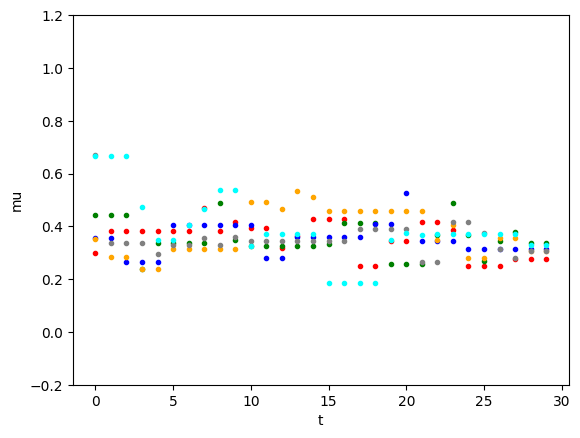

In [ ]:
cur_p = np.random.uniform(0, 1.0, size=[18,])
cur_likelihood = likelihood(train[:,1], train[:, 0], cur_p) * beta_pmf(cur_p, alpha, beta)
samples = []
accept_rates = []
fig,ax = plt.subplots(1,1)
ax.set_xlabel('t')
ax.set_ylabel('mu')
ax.set_ylim(-0.2,1.2)
colors = ['r','g','b','orange','gray','cyan']
for i in range(30):

    proposed_p = kernel(cur_p)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    # since our proposal probability is clearly symmetric, q(x'|x_t)/q(x_t|x') = 1
    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    samples.append(cur_p)

    #First 6 players
    for p in range(6):
        ax.plot(i, cur_p[p], c=colors[p], marker='.')
    display(fig)
    clear_output(True)
    plt.pause(1.0)

Let's remove plotting and run this for a long time:

In [ ]:
for i in tqdm.tqdm(range(2000)):

    proposed_p = kernel(cur_p)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    samples.append(cur_p)

100%|██████████| 2000/2000 [00:00<00:00, 17101.11it/s]


and compare it versus our analytical solution:

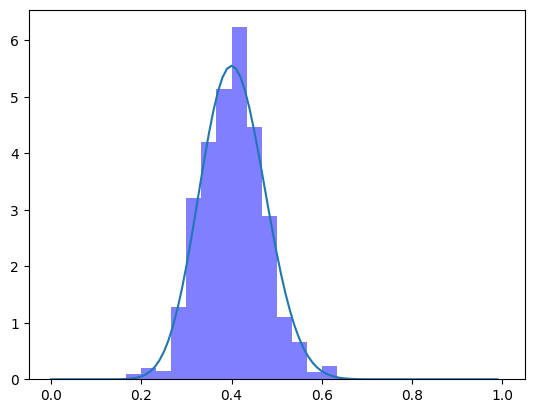

In [ ]:
# Throw away some samples at the front
samples = np.array(samples[100:])
fig, axes = plt.subplots(1,1)
axes.hist(samples[:,0], bins=30, range=(0,1), density=True, color='blue', alpha=0.5)

ps = np.arange(0,1,0.01)
post = get_posterior(train[0, 1], train[0, 0], alpha, beta)
axes.plot(ps, post(ps))
fig.show()

The histogram of the posterior samples almost matches perfectly with the true posterior distribution.

While our example ran reasonably fast, how efficient were we with the steps? A natural metric for efficiency is the
acceptance rate:

In [ ]:
print("accept rates", np.mean(accept_rates))

accept rates 0.35544608648056925


At around 30%, we are rejecting most samples produced by our proposal distribution. What would happen if we reduced the
step size to $0.03$?

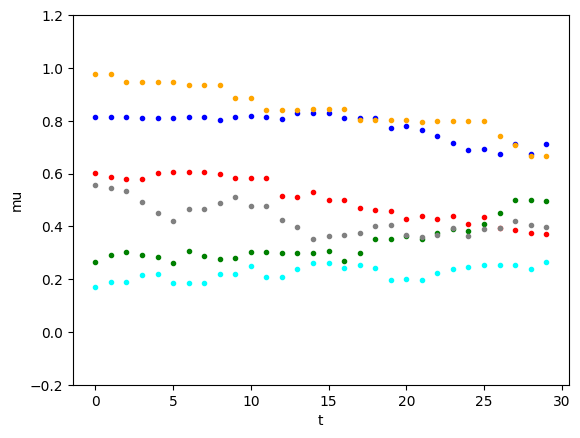

accept rates 0.7962962962962961


In [ ]:
cur_p = np.random.uniform(0, 1.0, size=[18,])
cur_likelihood = likelihood(train[:,1], train[:, 0], cur_p) * beta_pmf(cur_p, alpha, beta)
samples = []
accept_rates = []
fig,ax = plt.subplots(1,1)
ax.set_xlabel('t')
ax.set_ylabel('mu')
ax.set_ylim(-0.2,1.2)
colors = ['r','g','b','orange','gray','cyan']
for i in range(30):
    clear_output(True)
    proposed_p = kernel(cur_p, step_size=0.03)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    # since our proposal probability is clearly symmetric, q(x'|x_t)/q(x_t|x') = 1
    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    samples.append(cur_p)

    for p in range(6):
        ax.plot(i, cur_p[p], c=colors[p], marker='.')
    display(fig)

    plt.pause(1.0)

print("accept rates", np.mean(accept_rates))

We see that while the acceptance rate went up, we are making much less progress in reaching high-likelihood regions using the same
amount of steps. One way to describe this phenomenom is that the **mixing time** of our markov chain has increased, meaning
that it takes longer to reach its stationary distribution (which matches the true posterior).

Nonetheless, we see that changing the proposal distribution can give our Markov chain desirable properties.

## Metropolis-Hastings with Langevin dynamics (a.k.a. Langevin Monte-Carlo LMC)

Intuitively, we want our chain to move to high-probability regions under the posterior. We also happen to have access to
$p(D|\mu)p(\mu)$, which is proportional to $p(\mu|D)$. Hence, we might get faster convergence if we steer our proposal
distribution, in the direction of the gradients of the posterior, which is also proportional to $p(D|\mu)p(\mu)$. This is similar to gradient descent.

As we have often seen in MLE, it is more convenient to work with the gradients of the log-likelihood function instead of
the density itself. Hence, we'll write $f(\mu) = - \log \pi(\mu)$, where $\pi(\mu) = p(D|\mu)p(\mu)$.

A natural way to define our transition is then:

$$\mu' = \mu - \eta \nabla f(\mu) + \sqrt{2\eta} \xi, $$ with $\xi \sim {N}(0,1)$

The updates used in vanilla Metropolis-Hastings can be seen as drawn from a $0$-centered gaussian. Here, the expectation of new update is in the direction
of $\nabla f(\mu)$ with magnitude $\eta$. The addition of $\sqrt{2\eta} \xi$ ensures stochasticity, and has origins coming from the Brownian motion.

Since our proposal update is no longer symmetric, we need to adjust $\alpha$ to ensure that $\pi_\infty = p(\mu|D)$. It has
the form:

$$\alpha = \frac{\pi(\mu')\exp(-||\mu - \mu' + \eta\nabla f(\mu)||_2^2/4\eta)}{\pi(\mu)\exp(-||\mu' - \mu + \eta\nabla f(\mu)||_2^2/4\eta)}$$


### Gaussian Example
Let's use LMC to draw samples from a Gaussian distribution (without explicitly drawing from it).

For gaussians, we have $p(x) \propto \exp(-0.5* ||x-\mu||_2^2)$, thus the negative loglikelihood can be as $f(x) = ||x - \mu||^2/2 + C$
and $\nabla f(x) = x-\mu$.

Let's first see a version of LMC without the Metropolis-Hasting adjustment:

In [ ]:
def f(x):
    return .5 * np.sum(x**2)

def df(x):
    return x

def lmc(x0, eta, max_iter, trace_plot=False):
    x = x0
    trace = np.empty(shape=[0, 2])
    for it in range(max_iter):

        x_ = x - eta * df(x) + np.sqrt(2 * eta) * np.random.normal(0, 1, len(x))
        trace = np.vstack([trace, x])

        if trace_plot:
            ax.arrow(x[0], x[1], delta[0], delta[1])
            ax.plot(x[0], x[1], marker='.')
            display(fig)

            plt.pause(1.0)
            clear_output(True)
        x = x_
    return trace

x0 = np.array([10., 10.])
eta = .01
#fig,ax = plt.subplots(1,1)
#path_lmc = lmc(x0, eta, max_iter, trace_plot=True)

max_iter = 12000
path_lmc_full = lmc(x0, eta, max_iter, trace_plot=False)

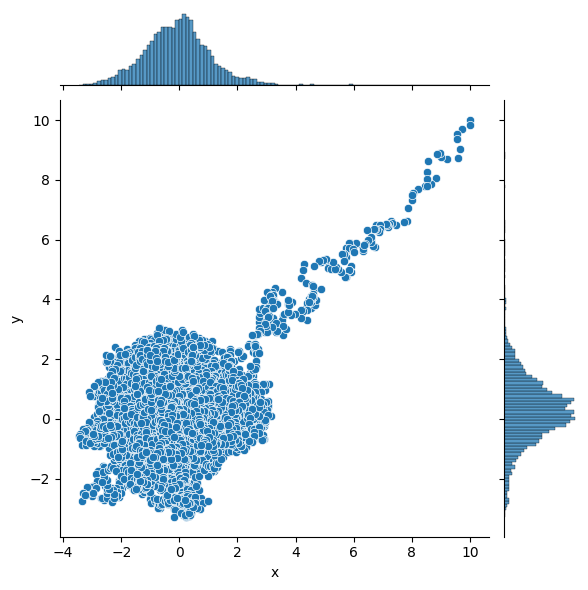

In [ ]:
import pandas as pd
import seaborn as sns
dataf = pd.DataFrame(path_lmc_full, columns = ['x','y'])
sns.jointplot(data=dataf, x="x", y="y")


Now let's add the rate calculation and rejection scheme:

In [ ]:
def lmcMH(x0, eta, max_iter):#, trace_plot=False):
    x = x0
    trace = np.empty(shape=[0, 2])
    for it in range(max_iter):

        delta = - eta * df(x) + np.sqrt(2 * eta) * np.random.normal(0, 1, len(x))
        x_ = x + delta

        rate = np.exp(f(x)-f(x_) + np.sum(-delta + eta*df(x))/(4*eta) - np.sum(delta + eta*df(x_))/(4*eta))
        # print(rate)
        u = np.random.uniform()
        accept =  u < rate
        if accept:
            x = x_
        trace = np.vstack([trace, x])

        # if trace_plot:
        #     if accept:
        #         ax.arrow(x[0], x[1], delta[0], delta[1], color='g')
        #     else:
        #         ax.arrow(x[0], x[1], delta[0], delta[1], color='r')
        #     ax.plot(x[0], x[1], marker='.')
        #     display(fig)

        #     plt.pause(1.0)
        #     clear_output(True)

    return trace

x0 = np.array([10., 10.])
eta = .01
max_iter = 100
#fig,ax = plt.subplots(1,1)
#path_lmcmh = lmcMH(x0, eta, max_iter, trace_plot=True)
max_iter = 12000
path_lmcmh_full = lmcMH(x0, eta, max_iter)#, trace_plot=False)

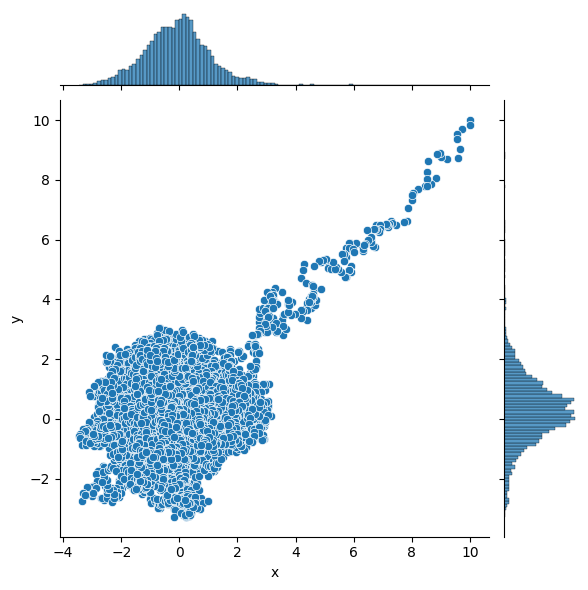

In [ ]:
import pandas as pd
import seaborn as sns
dataf = pd.DataFrame(path_lmc_full, columns = ['x','y'])
sns.jointplot(data=dataf, x="x", y="y")

Langevin dynamics in LMC was originally derived from the stochastic equations that describe Brownian motion of particles within a potential well.
A key simplifying assumption here was that Brownian particles had no inertia - instantaneous changes in velocity is allowed.
A more realistic model, with kinetic energy also taken into account, is the Hamiltonian dynamics model. This in turn inspires
Hamiltonian Monte Carlo, which is based on hamiltonian dynamics.

(A little spoiler: instead of adding noise to velocity, HMC adds noise to acceleration)

Cool demo: https://chi-feng.github.io/mcmc-demo/